In [1]:
from spectral import open_image
import numpy as np
import os
import matplotlib.pyplot as plt
import time

from pathlib import Path
from glob import glob
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans

from concurrent.futures import ProcessPoolExecutor

from datetime import datetime

In [2]:
hdr_files = []         # from subfolders

all_spectra = []       # each entry: [N, 489]
all_positions = []     # each entry: [N, 3]  -> (cube_id, y, x)
cube_ids = []          # cube file names


In [3]:
# cube subfolders are here
data_root = r'../data/nili_fossae_full_collection'

# find all HDR files in subfolders
for root, dirs, files in os.walk(data_root):
    for file in files:
        if file.endswith('.hdr'):
            hdr_files.append(os.path.join(root, file))

# try to open each HDR file - later will againbut i need to know they ar ok first
for path in hdr_files:
    try:
        img = open_image(path)
        print(f"[OK] Loaded {os.path.basename(path)} with shape {img.shape}")
    except Exception as e:
        print(f"[ERROR] Failed to load {path}: {e}")

print(f"Dry run finished.")

[OK] Loaded frt00004f75_07_if166j_mtr3.hdr with shape (2987, 1170, 489)
[OK] Loaded frt00005443_07_if166j_mtr3.hdr with shape (793, 825, 489)
[OK] Loaded frt00005850_07_if167j_mtr3.hdr with shape (1043, 990, 489)
[OK] Loaded frt00005a3e_07_if165j_mtr3.hdr with shape (713, 805, 489)
[OK] Loaded frt00005c5e_07_if166j_mtr3.hdr with shape (891, 890, 489)
[OK] Loaded frt000064d9_07_if166j_mtr3.hdr with shape (825, 818, 489)
[OK] Loaded frt0000652e_07_if166j_mtr3.hdr with shape (803, 831, 489)
[OK] Loaded frt000066a4_07_if166j_mtr3.hdr with shape (807, 837, 489)
[OK] Loaded frt00007bc8_07_if166j_mtr3.hdr with shape (844, 829, 489)
[OK] Loaded frt0000805f_07_if166j_mtr3.hdr with shape (777, 828, 489)
[OK] Loaded frt00008389_07_if166j_mtr3.hdr with shape (753, 840, 489)
[OK] Loaded frt00008530_07_if166j_mtr3.hdr with shape (772, 827, 489)
[OK] Loaded frt0000857f_07_if166j_mtr3.hdr with shape (797, 821, 489)
[OK] Loaded frt0000871c_07_if166j_mtr3.hdr with shape (761, 826, 489)
[OK] Loaded frt00

In [4]:
# rirectory where cleaned spectra and index files will be saved
save_dir = '../data/nili_fossae_preprocessed_spectra'
os.makedirs(save_dir, exist_ok=True)

# process a single cube
def process_cube(path):
    try:
        # get cube name from path
        name = os.path.basename(path).replace('.hdr', '')
        spectra_path = os.path.join(save_dir, f"{name}_spectra.npy")
        indices_path = os.path.join(save_dir, f"{name}_indices.npy")

        # skip if output already exists
        if os.path.exists(spectra_path) and os.path.exists(indices_path):
            return f"Skipped {name} (already processed)"

        # load hyperspectral cube from .hdr file
        img = open_image(path)
        data = img.load()  # shape = (height, width, bands)

        h, w, b = data.shape
        valid_spectra = []
        valid_indices = []

        # check every pixel in the cube
        for row in range(h):
            for col in range(w):
                spectrum = np.asarray(data[row, col, :])

                # reject NaNs, 65535 placeholders, and negative values
                if (
                    not np.any(np.isnan(spectrum)) and
                    not np.any(spectrum == 65535) and
                    not np.any(spectrum < 0)
                ):
                    # remove stitching artifact: bands 308 to 327 (inclusive)
                    spectrum = np.delete(spectrum, np.s_[308:328])

                    # store spectrum and pixel index
                    valid_spectra.append(spectrum)
                    valid_indices.append([row, col])

        # skip cube if no valid data found
        if not valid_spectra:
            return f"[WARNING] {name}: No valid pixels found"

        # convert to arrays
        valid_spectra = np.array(valid_spectra, dtype=np.float32)
        valid_indices = np.array(valid_indices, dtype=np.int32)

        
        # save cleaned spectra and indices
        np.save(spectra_path, valid_spectra)
        np.save(indices_path, valid_indices)

        return f"[OK] {name}: Saved {len(valid_spectra)} pixels"

    except Exception as e:
        return f"[ERROR] {name}: ERROR - {e}"

# ups cores to be used
cores_to_use = 2
# process all HDR files using parallel processes
print(f"Starting parallel processing ({len(hdr_files)} cubes, {cores_to_use} cores)...")

from concurrent.futures import as_completed

with ProcessPoolExecutor(max_workers=cores_to_use) as executor:
    future_to_path = {executor.submit(process_cube, path): path for path in hdr_files}
    for i, future in enumerate(as_completed(future_to_path), 1):
        try:
            result = future.result()
            print(f"[{i}/{len(hdr_files)}] {result}")
        except Exception as e:
            print(f"[{i}/{len(hdr_files)}] ERROR: {e}")


print("Finished.")

Starting parallel processing (137 cubes, 2 cores)...
[1/137] Skipped frt00004f75_07_if166j_mtr3 (already processed)
[2/137] Skipped frt00005850_07_if167j_mtr3 (already processed)
[3/137] Skipped frt00005443_07_if166j_mtr3 (already processed)
[4/137] Skipped frt00005a3e_07_if165j_mtr3 (already processed)
[5/137] Skipped frt00005c5e_07_if166j_mtr3 (already processed)
[6/137] Skipped frt000064d9_07_if166j_mtr3 (already processed)
[7/137] Skipped frt000066a4_07_if166j_mtr3 (already processed)
[8/137] Skipped frt0000652e_07_if166j_mtr3 (already processed)
[9/137] Skipped frt00007bc8_07_if166j_mtr3 (already processed)
[10/137] Skipped frt00008389_07_if166j_mtr3 (already processed)
[11/137] Skipped frt0000805f_07_if166j_mtr3 (already processed)
[12/137] Skipped frt00008530_07_if166j_mtr3 (already processed)
[13/137] Skipped frt0000871c_07_if166j_mtr3 (already processed)
[14/137] Skipped frt0000857f_07_if166j_mtr3 (already processed)
[15/137] Skipped frt000088d0_07_if166j_mtr3 (already process

Found 137 cubes

 Running clustering for k=5
Start Pass 1
[OK] Scaler fit: frt00003584_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt000037ae_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00003e12_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00003fb9_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt000047a3_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00004f75_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00005443_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00005850_07_if167j_mtr3_spectra.npy
[OK] Scaler fit: frt00005a3e_07_if165j_mtr3_spectra.npy
[OK] Scaler fit: frt00005c5e_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt000064d9_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt0000652e_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt000066a4_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00007bc8_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt0000805f_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00008389_07_if166j_mtr3_spectra.npy
[OK] Scaler fit: frt00008530_07_if166j_mtr3_sp

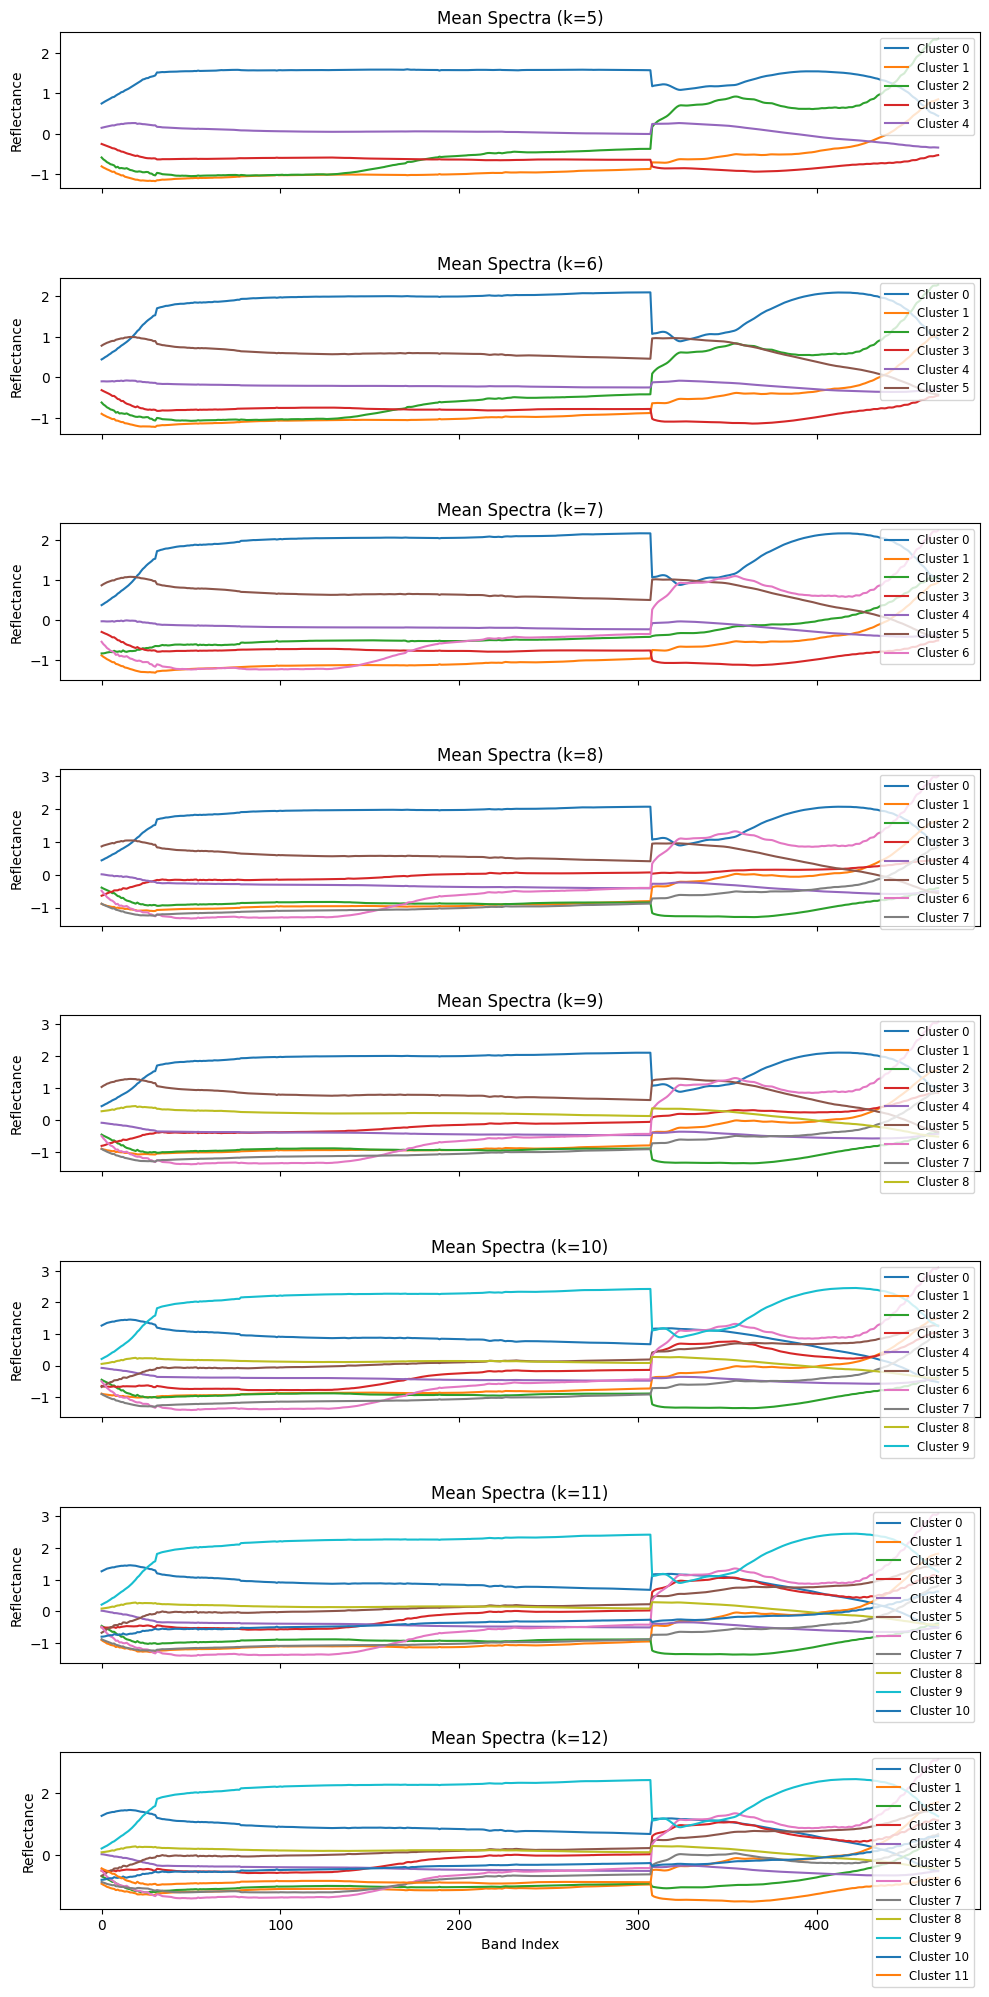

[YEPPIE] Combined plot saved to: ../results/clustering/mean_spectra_all.png


In [5]:
# config
preprocessed_dir = '../data/nili_fossae_preprocessed_spectra'
results_root = '../results/clustering'
batch_size = 10000
k_values = range(5, 13)
os.makedirs(results_root, exist_ok=True)
spectra_files = sorted(glob(os.path.join(preprocessed_dir, '*_spectra.npy')))
print(f"Found {len(spectra_files)} cubes")



# log file for timings
log_path = os.path.join(results_root, "clustering_timings.tsv")
log_header_written = os.path.exists(log_path)

# prepare timing log
log_file = open(log_path, 'a')
if not log_header_written:
    log_file.write("timestamp\tk\tduration_sec\tmessage\n")



# loop for each K
for n_clusters in k_values:
    print(f"\n Running clustering for k={n_clusters}")
    start_time = time.time()
    
    save_dir = os.path.join(results_root, f"k{n_clusters}")
    os.makedirs(save_dir, exist_ok=True)

    # Pass 1: Fit StandardScaler
    print("Start Pass 1")
    scaler = StandardScaler()
    for path in spectra_files:
        try:
            spectra = np.load(path)
            if spectra.ndim > 2:
                spectra = spectra.reshape(-1, spectra.shape[-1])
            scaler.partial_fit(spectra)
            print(f"[OK] Scaler fit: {os.path.basename(path)}")
        except Exception as e:
            print(f"[ERROR] Scaler fit failed: {path} | {e}")
    print("Finished Pass 1")
    

    # Pass 2: Fit MiniBatchKMeans
    print("Start Pass 2")
    kmeans = MiniBatchKMeans(n_clusters=n_clusters, batch_size=batch_size, random_state=42)
    for path in spectra_files:
        try:
            spectra = np.load(path)
            if spectra.ndim > 2:
                spectra = spectra.reshape(-1, spectra.shape[-1])
            scaled = scaler.transform(spectra)
            kmeans.partial_fit(scaled)
            print(f"[OK] KMeans partial fit: {os.path.basename(path)}")
        except Exception as e:
            print(f"[ERROR] KMeans fit failed: {path} | {e}")
    print("Finished Pass 2")
    

    # Pass 3: Predict labels
    print("Start Pass 3")
    labels_all = []
    for path in spectra_files:
        try:
            spectra = np.load(path)
            if spectra.ndim > 2:
                spectra = spectra.reshape(-1, spectra.shape[-1])
            scaled = scaler.transform(spectra)
            labels = kmeans.predict(scaled)
            labels_all.append(labels)
            print(f"[OK] Labels assigned: {os.path.basename(path)}")
        except Exception as e:
            print(f"[ERROR] Labeling failed: {path} | {e}")

    print("Finished Pass 3")
    

    # save
    labels_all = np.concatenate(labels_all)
    np.save(os.path.join(save_dir, f"labels_k{n_clusters}.npy"), labels_all)
    np.save(os.path.join(save_dir, f"centroids_k{n_clusters}.npy"), kmeans.cluster_centers_)
    print(f"Saved results to {save_dir}")

    # end timing + log
    end_time = time.time()
    duration = round(end_time - start_time, 2)
    timestamp = datetime.now().isoformat(timespec='seconds')
    log_file.write(f"{timestamp}\t{n_clusters}\t{duration}\tSuccess\n")
    log_file.flush()


log_file.close()
print(f"\n Timing log updated at: {log_path}")


# plot comparisaon
print("\n Generating combined cluster spectra plot...")
fig, axes = plt.subplots(len(k_values), 1, figsize=(10, 2.5 * len(k_values)), sharex=True)

for i, k in enumerate(k_values):
    try:
        centroids = np.load(os.path.join(results_root, f"k{k}", f"centroids_k{k}.npy"))
        ax = axes[i]
        for j in range(k):
            ax.plot(centroids[j], label=f"Cluster {j}")
        ax.set_ylabel("Reflectance")
        ax.set_title(f"Mean Spectra (k={k})")
        ax.legend(loc="upper right", fontsize="small")
    except Exception as e:
        axes[i].text(0.5, 0.5, f"Failed to load k={k}", ha='center', va='center', transform=axes[i].transAxes)
        print(f"[ERROR] Failed to plot k={k}: {e}")

axes[-1].set_xlabel("Band Index")
plt.tight_layout()
comparison_plot_path = os.path.join(results_root, "mean_spectra_all.png")
plt.savefig(comparison_plot_path)
plt.show()

print(f"[YEPPIE] Combined plot saved to: {comparison_plot_path}")


In [3]:
# conf
preprocessed_dir = '../data/nili_fossae_preprocessed_spectra'
results_root = '../results/labelmaps'
labels_dir = '../results/clustering'
k_values = list(range(5, 13))
index_files = sorted(glob(os.path.join(preprocessed_dir, '*_indices.npy')))
os.makedirs(results_root, exist_ok=True)

# reconstruct
for k in k_values:
    print(f"\n Reconstructing labelmaps for k={k}")
    
    labelmap_dir = os.path.join(results_root, f'k{k}')
    os.makedirs(labelmap_dir, exist_ok=True)

    labels_path = os.path.join(labels_dir, f'k{k}', f'labels_k{k}.npy')
    all_labels = np.load(labels_path)

    offset = 0
    for index_path in index_files:
        cube_name = os.path.basename(index_path).replace('_indices.npy', '')
        indices = np.load(index_path)
        h = indices[:, 0].max() + 1
        w = indices[:, 1].max() + 1
        labelmap = np.full((h, w), -1, dtype=np.int16)

        num_pixels = len(indices)
        labels_slice = all_labels[offset:offset + num_pixels]

        for (row, col), label in zip(indices, labels_slice):
            labelmap[row, col] = label

        # Save as .npy
        np.save(os.path.join(labelmap_dir, f"{cube_name}_labelmap.npy"), labelmap)

        offset += num_pixels
        print(f"[OK] {cube_name}: saved labelmap (k={k})")

print("\n All labelmaps reconstructed.")


 Reconstructing labelmaps for k=5
[OK] frt00003584_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt000037ae_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00003e12_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00003fb9_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt000047a3_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00004f75_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00005443_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00005850_07_if167j_mtr3: saved labelmap (k=5)
[OK] frt00005a3e_07_if165j_mtr3: saved labelmap (k=5)
[OK] frt00005c5e_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt000064d9_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt0000652e_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt000066a4_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00007bc8_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt0000805f_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00008389_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt00008530_07_if166j_mtr3: saved labelmap (k=5)
[OK] frt0000857f_07_if166j_mtr3: saved labelmap